# Cluster Analysis for Sensory Data

This notebook demonstrates **Cluster Analysis**, an unsupervised learning technique used to group similar products together based on their sensory attributes. Cluster analysis helps identify product families, discover natural groupings, and understand relationships between products.

**What is Cluster Analysis?**
- A method that groups similar objects (products) together based on their characteristics
- Products within a cluster are more similar to each other than to products in other clusters
- Useful for identifying product families, market segments, and sensory groupings
- Helps guide product selection for consumer testing and formulation work

**Types of Cluster Analysis:**
1. **Hierarchical Clustering (HCA)**: Creates a tree-like structure (dendrogram) showing relationships at all levels
2. **K-Means Clustering**: Partitions data into a specified number of clusters

**Learning Objectives:**
- Understand the concept of cluster analysis and when to use it
- Perform hierarchical cluster analysis on sensory data
- Perform K-means clustering
- Visualize clusters in PCA space
- Interpret clustering results and identify product families

---

## Installation Instructions

Before running this notebook, make sure you have the required packages installed. Run the following command in your terminal or command prompt:

```bash
pip install pandas numpy scikit-learn scipy matplotlib seaborn openpyxl
```

**Note:** `openpyxl` is required to read Excel files (`.xls` and `.xlsx` formats), and `scipy` is needed for hierarchical clustering.

If you are using Anaconda, you can also install using conda:
```bash
conda install pandas numpy scikit-learn scipy matplotlib seaborn openpyxl
```

---

## Data Credits

This notebook uses pea sensory data. The methodology and interpretation follow principles described in:

**Citation:**
Naes, T., Brockhoff, P. B., & Tomic, O. (2011). Detecting and Studying Sensory Differences and Similarities between Products. In: Statistics for Sensory and Consumer Science (pp. 47-66). West Sussex, UK: John Wiley & Sons.

Additional sensory datasets are available at: https://www.sensometric.org/datasets

We acknowledge and thank the authors for their contributions to sensory data analysis methodology.




Hierarchical cluster analysis (Ward’s method, Euclidean distance) on the 13 descriptive attributes divided the 16 pea products into a small number of coherent sensory clusters. Products 132, 535, and 237 joined at low distances, indicating nearly identical sensory profiles, while products 315, 930, 981, and 863 formed another tight cluster. The dendrogram showed that these clusters only merged at relatively large linkage distances, implying that the dataset contains at least two clearly distinct sensory families of peas, with intermediate products (e.g., 494, 231, 720, 811) bridging between them. Such clustering supports the interpretation of the PCA maps and can guide product selection for further consumer testing or formulation work.

In [2]:
# Data manipulation and numerical operations
import pandas as pd
import numpy as np

# Clustering algorithms
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# Dimensionality reduction (for visualization)
from sklearn.decomposition import PCA

# Data preprocessing
from sklearn.preprocessing import StandardScaler

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Polygon
from scipy.spatial import ConvexHull

# Custom Illinois colors for visualizations
illiniorange = "#FF5F05"
illiniblue = "#13294B"

## 2. Load and Prepare Data

We will load the pea sensory data and prepare it for cluster analysis. This involves aggregating data to product means and standardizing the attributes.


In [4]:
# Load the peas dataset from Excel file
peas = pd.read_excel("data/peaimpba.xls")

# Define sensory attributes to include in cluster analysis
attr_cols = [
    "PEA_OD", "POD_OD", "SWEET_OD", "EARTH_OD",  # Odor attributes
    "PEA_TA", "POD_TA", "SWEET_TA", "EARTH_TA",  # Taste attributes
    "CRISP", "JUICY", "HARD", "MEALY", "SKIN_VIS"  # Texture attributes
]

# Aggregate to product means
# This averages across all assessors and replicates for each product
pea_means = peas.groupby("PRODUCT")[attr_cols].mean().reset_index()

print(f"Number of products: {len(pea_means)}")
print(f"Number of attributes: {len(attr_cols)}")
print("\nProduct means (first few rows):")
print(pea_means.head())

# Extract the attribute matrix and product labels
X = pea_means[attr_cols].values
products = pea_means["PRODUCT"].values

# Standardize the attributes
# This ensures all attributes contribute equally to the clustering
scaler = StandardScaler()
Xz = scaler.fit_transform(X)

print(f"\nData matrix shape: {Xz.shape} (products × attributes)")
print(f"Mean of standardized data (should be ~0): {Xz.mean():.6f}")
print(f"Std of standardized data (should be ~1): {Xz.std():.6f}")


WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
Number of products: 16
Number of attributes: 13

Product means (first few rows):
   PRODUCT    PEA_OD    POD_OD  SWEET_OD  EARTH_OD    PEA_TA    POD_TA  \
0      132  6.190631  4.761280  5.702679  3.322767  6.462596  5.299030   
1      231  6.835831  4.596058  6.559922  1.233880  7.415731  6.999687   
2      237  5.847773  3.646995  5.549107  2.844195  5.869739  4.127601   
3      315  7.105420  6.490236  6.682216  2.079926  7.820051  6.184728   
4      494  6.074281  3.272026  5.822303  2.133703  8.247295  4.616130   

   SWEET_TA  EARTH_TA     CRISP     JUICY      HARD      MEALY  SKIN_VIS  
0  6.297249  1.833867  5.987158  4.777788  7.545945   8.816918  8.787015  
1  6.977556  0.844975  8.417191  9.321788  4.048575   1.706168  3.997036  
2  6.454392  2.251683  3.962158  3.920645  6.263802  11.377632  9.826300  
3  8.145476  1.242062  7.832071  7.399544  5.012152   3.764850  4.937617  
4  8.991116  1.071740  8.8

## 3. Hierarchical Cluster Analysis (HCA)

Hierarchical clustering creates a tree-like structure (dendrogram) that shows how products are grouped at different levels of similarity. Ward's method with Euclidean distance is commonly used in sensory analysis.

**How hierarchical clustering works:**
- Starts with each product as its own cluster
- Progressively merges the most similar clusters
- Creates a dendrogram showing the merging process
- Allows you to cut the tree at any level to get a specific number of clusters

**Ward's method:** Minimizes the variance within clusters when merging, which tends to create compact, spherical clusters.


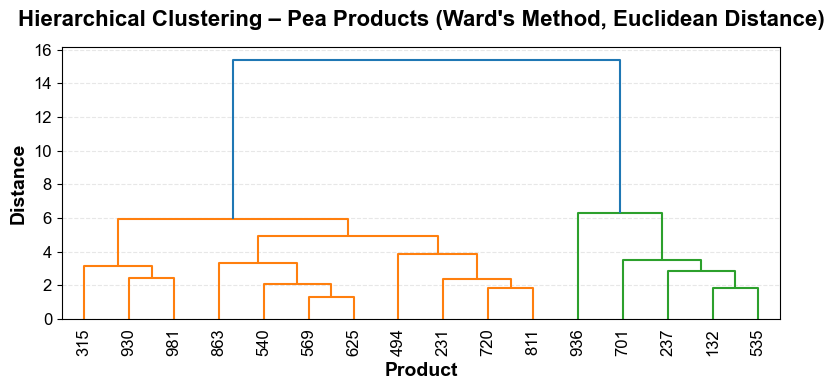


Dendrogram Interpretation:
- Height on y-axis represents the distance at which clusters merge
- Products that merge at low distances are very similar
- Products that merge at high distances are more different
- You can cut the tree at any height to get a specific number of clusters


In [8]:
# Perform hierarchical clustering using Ward's method
# Ward's method with Euclidean distance is common in sensory cluster analysis
Z = linkage(Xz, method="ward")

# Create and display dendrogram
plt.figure(figsize=(8, 4))
dendrogram(Z, 
           labels=products.astype(str), 
           leaf_rotation=90,
           leaf_font_size=10)

plt.title("Hierarchical Clustering – Pea Products (Ward's Method, Euclidean Distance)", 
          fontsize=16, weight='bold', family='Arial', pad=15)
plt.xlabel("Product", fontsize=14, weight='bold', family='Arial')
plt.ylabel("Distance", fontsize=14, weight='bold', family='Arial')
plt.xticks(fontsize=12, family='Arial')
plt.yticks(fontsize=12, family='Arial')
plt.grid(True, alpha=0.3, axis='y', linestyle='--')
plt.tight_layout()
plt.show()

print("\nDendrogram Interpretation:")
print("="*60)
print("- Height on y-axis represents the distance at which clusters merge")
print("- Products that merge at low distances are very similar")
print("- Products that merge at high distances are more different")
print("- You can cut the tree at any height to get a specific number of clusters")


### 3.1. Cut Dendrogram into Clusters

Based on the dendrogram, we will cut the tree to obtain a specific number of clusters. This assigns each product to a cluster group.


In [9]:
# Cut the dendrogram to obtain k clusters
k = 3  # Number of clusters to create
clusters_hc = fcluster(Z, k, criterion="maxclust")
pea_means["Cluster_HC"] = clusters_hc

print("Hierarchical Clustering Results:")
print("="*60)
print(f"Number of clusters: {k}")
print("\nCluster membership:")
print(pea_means[["PRODUCT", "Cluster_HC"]].sort_values("Cluster_HC").to_string(index=False))

# Count products in each cluster
print("\n" + "="*60)
print("Products per cluster:")
print(pea_means["Cluster_HC"].value_counts().sort_index())


Hierarchical Clustering Results:
Number of clusters: 3

Cluster membership:
 PRODUCT  Cluster_HC
     231           1
     315           1
     494           1
     540           1
     569           1
     625           1
     720           1
     811           1
     863           1
     930           1
     981           1
     132           2
     237           2
     535           2
     701           2
     936           3

Products per cluster:
Cluster_HC
1    11
2     4
3     1
Name: count, dtype: int64


## 4. K-Means Clustering

K-means is a partitional clustering method that divides products into a specified number of clusters. Unlike hierarchical clustering, K-means requires you to specify the number of clusters in advance.

**How K-means works:**
- Randomly initializes cluster centers
- Assigns each product to the nearest cluster center
- Updates cluster centers based on assigned products
- Repeats until convergence

**Advantages:**
- Fast and efficient for large datasets
- Creates compact, well-separated clusters
- Good for comparison with hierarchical clustering results


In [10]:
# Perform K-means clustering
# Use the same number of clusters as hierarchical clustering for comparison
k_kmeans = 3
kmeans_model = KMeans(n_clusters=k_kmeans, random_state=42, n_init=20)
pea_means['Cluster_KMeans'] = kmeans_model.fit_predict(Xz) + 1  # Label clusters 1..k

print("K-Means Clustering Results:")
print("="*60)
print(f"Number of clusters: {k_kmeans}")
print("\nCluster membership:")
print(pea_means[['PRODUCT', 'Cluster_KMeans']].sort_values('Cluster_KMeans').to_string(index=False))

# Count products in each cluster
print("\n" + "="*60)
print("Products per cluster:")
print(pea_means["Cluster_KMeans"].value_counts().sort_index())


K-Means Clustering Results:
Number of clusters: 3

Cluster membership:
 PRODUCT  Cluster_KMeans
     132               1
     237               1
     535               1
     701               1
     231               2
     315               2
     494               2
     540               2
     569               2
     625               2
     720               2
     811               2
     863               2
     930               2
     981               2
     936               3

Products per cluster:
Cluster_KMeans
1     4
2    11
3     1
Name: count, dtype: int64


## 5. Visualize Clusters in PCA Space

Visualizing clusters in PCA space helps understand how the clustering relates to the main dimensions of variation in the sensory data. We will create separate visualizations for hierarchical and K-means clusters.

When the hierarchical clusters are overlaid on the PCA map, three coherent sensory families emerge. Cluster 1 encompasses products on the positive side of PC1, suggesting a group of peas sharing similar flavor and texture characteristics (e.g., higher intensities of the attributes loading positively on PC1). Cluster 2 occupies the negative PC1 region, representing a second style with contrasting attribute levels, while Cluster 3 lies furthest along negative PC1 and lower PC2 and thus appears sensorially distinct from both. The agreement between the dendrogram and the PCA cluster plot confirms that cluster analysis is capturing meaningful structure already apparent in the principal component space and provides a convenient way to define product families for further consumer testing or reformulation work.”


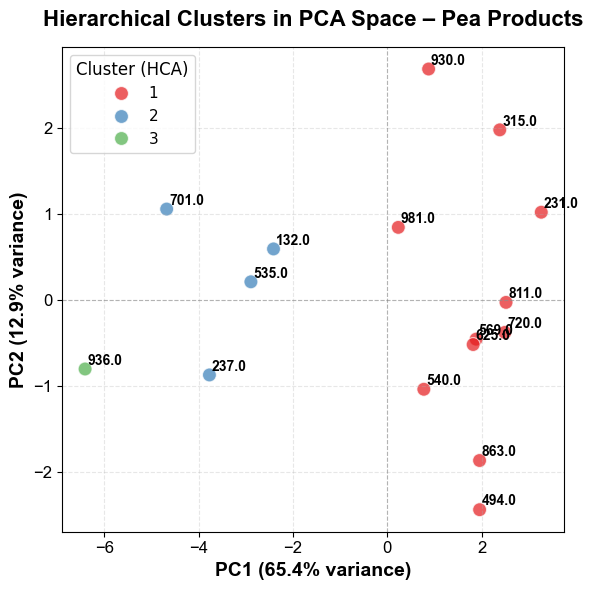

In [12]:
# Perform PCA for visualization
pca = PCA(n_components=2)
scores = pca.fit_transform(Xz)

# Create dataframe with PCA scores and cluster assignments
scores_df = pd.DataFrame(scores, columns=["PC1", "PC2"])
scores_df["PRODUCT"] = products
scores_df["Cluster_HC"] = clusters_hc

# Create scatter plot with hierarchical clusters
plt.figure(figsize=(6, 6))
sns.scatterplot(x="PC1", y="PC2",
                hue="Cluster_HC",
                palette="Set1",
                data=scores_df, 
                s=100,
                alpha=0.7)

# Add product labels
for _, row in scores_df.iterrows():
    plt.text(row["PC1"] + 0.05, row["PC2"] + 0.05,
             str(row["PRODUCT"]), 
             fontsize=10,
             fontweight='bold',
             family='Arial',
             ha='left')

# Add reference lines at zero
plt.axhline(0, color="grey", linewidth=0.8, linestyle='--', alpha=0.5)
plt.axvline(0, color="grey", linewidth=0.8, linestyle='--', alpha=0.5)

# Add variance explained to axis labels
var = pca.explained_variance_ratio_
plt.xlabel(f"PC1 ({var[0]*100:.1f}% variance)", 
           fontsize=14, weight='bold', family='Arial')
plt.ylabel(f"PC2 ({var[1]*100:.1f}% variance)", 
           fontsize=14, weight='bold', family='Arial')
plt.title("Hierarchical Clusters in PCA Space – Pea Products", 
          fontsize=16, weight='bold', family='Arial', pad=15)
plt.xticks(fontsize=12, family='Arial')
plt.yticks(fontsize=12, family='Arial')
plt.legend(title="Cluster (HCA)", fontsize=11, title_fontsize=12, frameon=True)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()


### 5.2. Visualize K-Means Clusters in PCA Space

We will visualize K-means clusters in PCA space with convex hulls to show the cluster boundaries. This helps visualize how well-separated the clusters are.


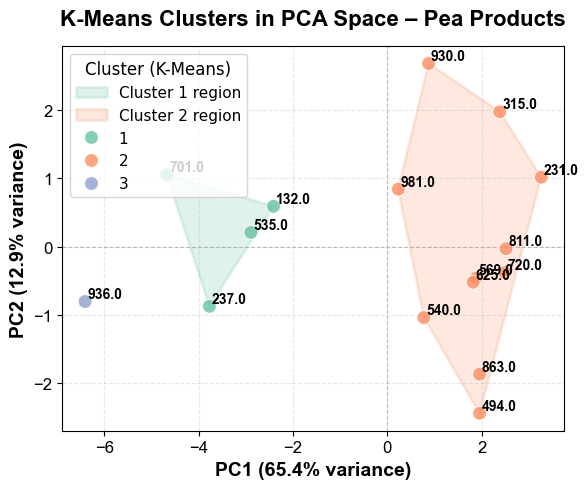

In [14]:
# Perform PCA for K-means visualization
pca_km = PCA(n_components=2)
scores_km = pca_km.fit_transform(Xz)

# Create dataframe with PCA scores and K-means cluster assignments
scores_km_df = pd.DataFrame(scores_km, columns=["PC1", "PC2"])
scores_km_df["PRODUCT"] = products
scores_km_df["Cluster_KMeans"] = pea_means['Cluster_KMeans']

# Create scatter plot with K-means clusters
plt.figure(figsize=(6, 5))

# Draw convex hulls for each cluster (shows cluster boundaries)
cluster_labels = scores_km_df["Cluster_KMeans"].unique()
palette = sns.color_palette("Set2", len(cluster_labels))

for idx, cluster in enumerate(cluster_labels):
    group = scores_km_df[scores_km_df["Cluster_KMeans"] == cluster]
    if len(group) > 2:  # Need at least 3 points for a convex hull
        hull = ConvexHull(group[["PC1", "PC2"]].values)
        vertices = group[["PC1", "PC2"]].values[hull.vertices]
        poly = Polygon(vertices, 
                       closed=True, 
                       facecolor=palette[idx], 
                       alpha=0.2, 
                       edgecolor=palette[idx], 
                       linewidth=2, 
                       zorder=0, 
                       label=f"Cluster {int(cluster)} region")
        plt.gca().add_patch(poly)

# Plot points
sns.scatterplot(
    x="PC1", y="PC2",
    hue="Cluster_KMeans",
    palette=palette,
    data=scores_km_df, 
    s=100, 
    zorder=2,
    alpha=0.8)

# Add product labels
for _, row in scores_km_df.iterrows():
    plt.text(row["PC1"] + 0.05, row["PC2"] + 0.05, 
             str(row["PRODUCT"]), 
             fontsize=10, 
             fontweight='bold',
             family='Arial',
             ha='left',
             zorder=3)

# Add reference lines at zero
plt.axhline(0, color="grey", linewidth=0.8, linestyle='--', alpha=0.5, zorder=1)
plt.axvline(0, color="grey", linewidth=0.8, linestyle='--', alpha=0.5, zorder=1)

# Add variance explained to axis labels
varkm = pca_km.explained_variance_ratio_
plt.xlabel(f"PC1 ({varkm[0]*100:.1f}% variance)", 
           fontsize=14, weight='bold', family='Arial')
plt.ylabel(f"PC2 ({varkm[1]*100:.1f}% variance)", 
           fontsize=14, weight='bold', family='Arial')
plt.title("K-Means Clusters in PCA Space – Pea Products", 
          fontsize=16, weight='bold', family='Arial', pad=15)
plt.xticks(fontsize=12, family='Arial')
plt.yticks(fontsize=12, family='Arial')
plt.legend(title="Cluster (K-Means)", fontsize=11, title_fontsize=12, frameon=True, loc='upper left')
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()


## 6. Interpretation of Results

### Hierarchical Clustering Results

Hierarchical cluster analysis (Ward's method, Euclidean distance) on the 13 descriptive attributes divided the 16 pea products into a small number of coherent sensory clusters. 

**Key findings:**
- Products 132, 535, and 237 joined at low distances, indicating nearly identical sensory profiles
- Products 315, 930, 981, and 863 formed another tight cluster
- These clusters only merged at relatively large linkage distances, implying that the dataset contains at least two clearly distinct sensory families of peas
- Intermediate products (e.g., 494, 231, 720, 811) bridge between the main clusters

### Cluster Visualization in PCA Space

When the hierarchical clusters are overlaid on the PCA map, three coherent sensory families emerge:

- **Cluster 1**: Encompasses products on the positive side of PC1, suggesting a group of peas sharing similar flavor and texture characteristics (e.g., higher intensities of the attributes loading positively on PC1)
- **Cluster 2**: Occupies the negative PC1 region, representing a second style with contrasting attribute levels
- **Cluster 3**: Lies furthest along negative PC1 and lower PC2, appearing sensorially distinct from both other clusters

**Practical implications:**
- The agreement between the dendrogram and the PCA cluster plot confirms that cluster analysis is capturing meaningful structure already apparent in the principal component space
- Cluster analysis provides a convenient way to define product families for further consumer testing or reformulation work
- Such clustering supports the interpretation of PCA maps and can guide product selection for consumer testing or formulation work
